I know that there's a lot of repeated code, but maybe later :)

In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import packages.mine_generic as mine_g
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Food:

In [29]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'

cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Food'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [30]:
import statsmodels.api as sm

max_lag = 12

def train_pca(X_train,n_components):
    #X_train = cat_df[cat_df.index <= '2015-12-31'].fillna(0)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    pca = PCA(n_components = n_components)

    factor_train = pd.DataFrame(pca.fit_transform(X_train_scaled))
    return factor_train


# Function to fit OLS model with a given lag length and calculate BIC
def tune_lags_pca_regress_bic(X_train, y_train, lags, horizon = 1, verbose = 1):


    # PCA:
    X_train_temp = X_train.iloc[:-horizon, :]

    factor_train = train_pca(X_train_temp,n_components=5)
    # lagged values of y:
    y_lagged = pd.DataFrame()
    for lag in range(0, lags + 1):
        y_lagged[f'Lag_{lag}'] = y_train.shift(lag)

    # Combine lagged values and additional predictors
    X_pca_with_lags = pd.concat([y_lagged.reset_index(), factor_train], axis= 1)
    X_pca_with_lags.dropna(inplace=True)
    X_pca_with_lags = X_pca_with_lags.reset_index(drop=True)

    date_here = X_pca_with_lags.loc[:, 'date']
    X_pca_with_lags = X_pca_with_lags.drop(columns='date')
    X_pca_with_lags_with_const = sm.add_constant(X_pca_with_lags)

    # y:
    y_train_temp = y_train[lags+horizon:]


    # Fit OLS regression model
    model = sm.OLS(y_train_temp.reset_index(drop = True), X_pca_with_lags_with_const)
    results = model.fit()
    
    # Calculate BIC
    bic = results.bic
    
    if verbose == 1:
        print(f'Horizon {horizon}, lag {lags}')
        print(f'X period: {date_here.iloc[0]} - {date_here.iloc[-1]}')
        print(f'y period: {y_train_temp.index[0]} - {y_train_temp.index[-1]}')

    return bic


In [31]:
horizon = 1
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Horizon 1, lag 0
X period: 1997-02-28 00:00:00 - 2015-11-30 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 1
X period: 1997-03-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 2
X period: 1997-04-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 3
X period: 1997-05-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 4
X period: 1997-06-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 5
X period: 1997-07-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 6
X period: 1997-08-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00

In [32]:
horizon = 2
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Horizon 2, lag 0
X period: 1997-03-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 1
X period: 1997-04-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 2
X period: 1997-05-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 3
X period: 1997-06-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 4
X period: 1997-07-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 5
X period: 1997-08-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 6
X period: 1997-09-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00

In [6]:
horizon = 3
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Horizon 3, lag 0
X period: 1997-04-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 1
X period: 1997-05-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 2
X period: 1997-06-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 3
X period: 1997-07-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 4
X period: 1997-08-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 5
X period: 1997-09-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-12-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 6
X period: 1997-10-31 00:00:00 - 2015-09-30 00:00:00
y period: 1998-01-31 00:00:00 - 2015-12-31 00

# Energy:

In [7]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'

cat_short = 'energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Energy'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Energy group:  14


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h =1

In [8]:
horizon = 1
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


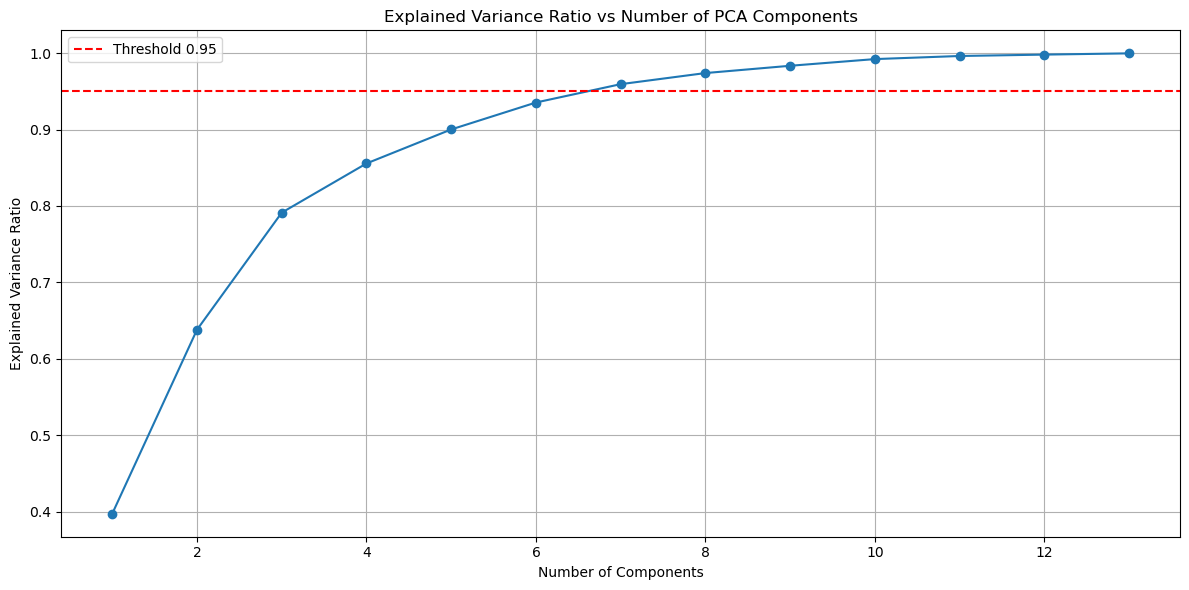

In [9]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define a range of n_components to explore
n_components_range = range(1, 14, 1)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [10]:
n_components = 3

bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 1, lag 0
X period: 1997-02-28 00:00:00 - 2015-11-30 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 1
X period: 1997-03-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 2
X period: 1997-04-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 3
X period: 1997-05-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 4
X period: 1997-06-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 5
X period: 1997-07-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 6
X period: 1997-08-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 7
X period: 1997-09-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 8
X period: 1997-

## h =2

In [11]:
horizon = 2
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00


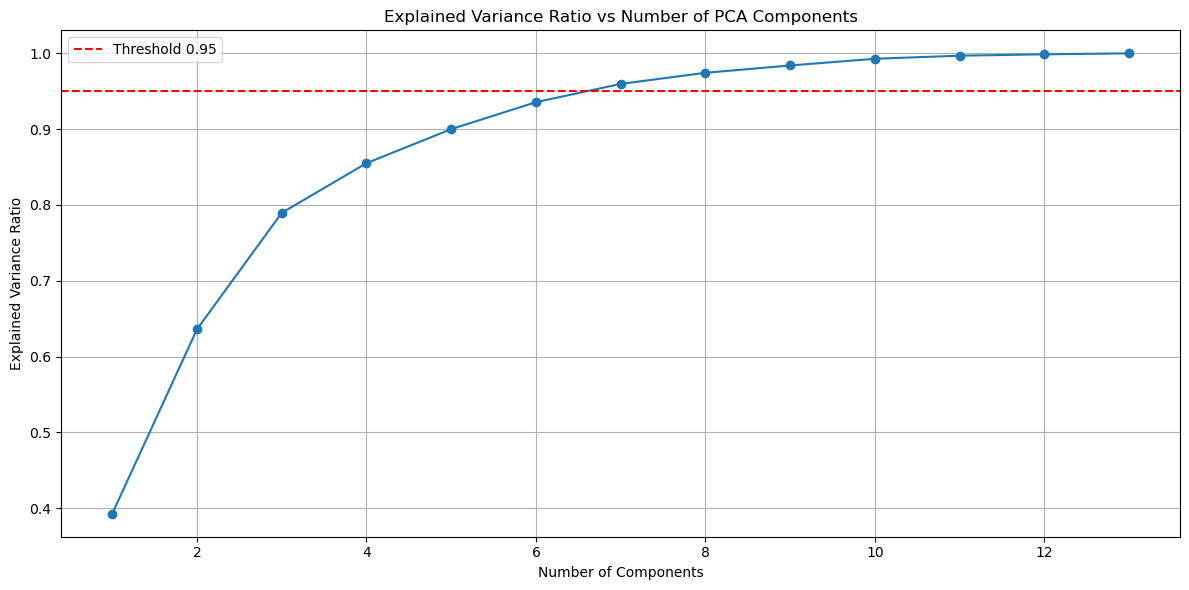

In [12]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define a range of n_components to explore
n_components_range = range(1, 14, 1)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
n_components = 3
bic_values_h2 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h2.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h2)
lowest_bic = min(bic_values_h2)

print("BIC values for different lag lengths:", bic_values_h2)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 2, lag 0
X period: 1997-03-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 1
X period: 1997-04-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 2
X period: 1997-05-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 3
X period: 1997-06-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 4
X period: 1997-07-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 5
X period: 1997-08-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 6
X period: 1997-09-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 7
X period: 1997-10-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-12-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 8
X period: 1997-

## h = 3

In [14]:
horizon = 3
n_components = 3

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

bic_values_h3 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon, verbose=0)
    bic_values_h3.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h3)
lowest_bic = min(bic_values_h3)

print("BIC values for different lag lengths:", bic_values_h3)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
BIC values for different lag lengths: [1219.160075662049, 1219.9589517509746, 1220.582199522055, 1218.8942247874404, 1218.3262833618764, 1218.6122518898603, 1219.2529942025915, 1218.984744339552, 1215.31045527561, 1186.2678843219066, 1182.6583841480738, 1183.3418372318831, 1170.4700821029]
Optimal lag length chosen by BIC: 12
Lowest BIC: 1170.4700821029


# Services:

In [15]:
cat_short = 'services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Services'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Services group:  148


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [16]:
horizon = 1
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


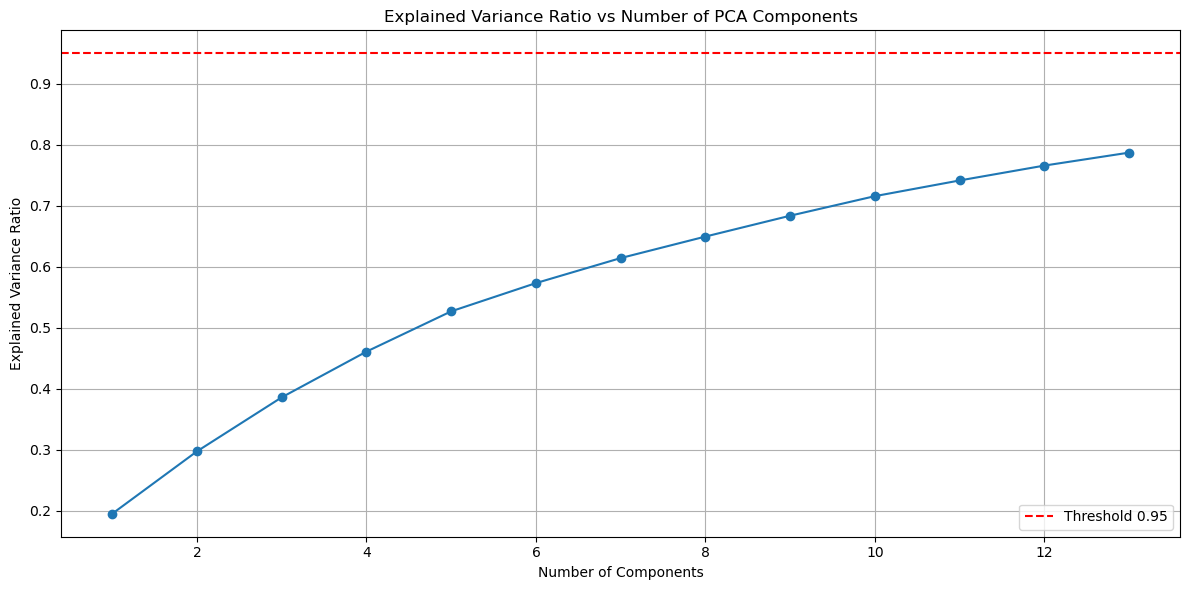

In [17]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define a range of n_components to explore
n_components_range = range(1, 14, 1)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
n_components = 5

bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 1, lag 0
X period: 1997-02-28 00:00:00 - 2015-11-30 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 1
X period: 1997-03-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 2
X period: 1997-04-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 3
X period: 1997-05-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 4
X period: 1997-06-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 5
X period: 1997-07-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 6
X period: 1997-08-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 7
X period: 1997-09-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 8
X period: 1997-

In [19]:
horizon = 2
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

n_components = 5

bic_values_h2 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h2.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h2)
lowest_bic = min(bic_values_h2)

print("BIC values for different lag lengths:", bic_values_h2)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Horizon 2, lag 0
X period: 1997-03-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 1
X period: 1997-04-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 2
X period: 1997-05-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 3
X period: 1997-06-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 4
X period: 1997-07-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 5
X period: 1997-08-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 6
X period: 1997-09-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00

In [20]:
horizon = 3
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

n_components = 5

bic_values_h3 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h3.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h3)
lowest_bic = min(bic_values_h3)

print("BIC values for different lag lengths:", bic_values_h3)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Horizon 3, lag 0
X period: 1997-04-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 1
X period: 1997-05-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 2
X period: 1997-06-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 3
X period: 1997-07-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 4
X period: 1997-08-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 5
X period: 1997-09-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-12-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 6
X period: 1997-10-31 00:00:00 - 2015-09-30 00:00:00
y period: 1998-01-31 00:00:00 - 2015-12-31 00

# NEIG:

In [21]:
cat_short = 'neig'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Non-energy industrial goods (NEIG)'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Non-energy industrial goods (NEIG) group:  302


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [22]:
horizon = 1
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


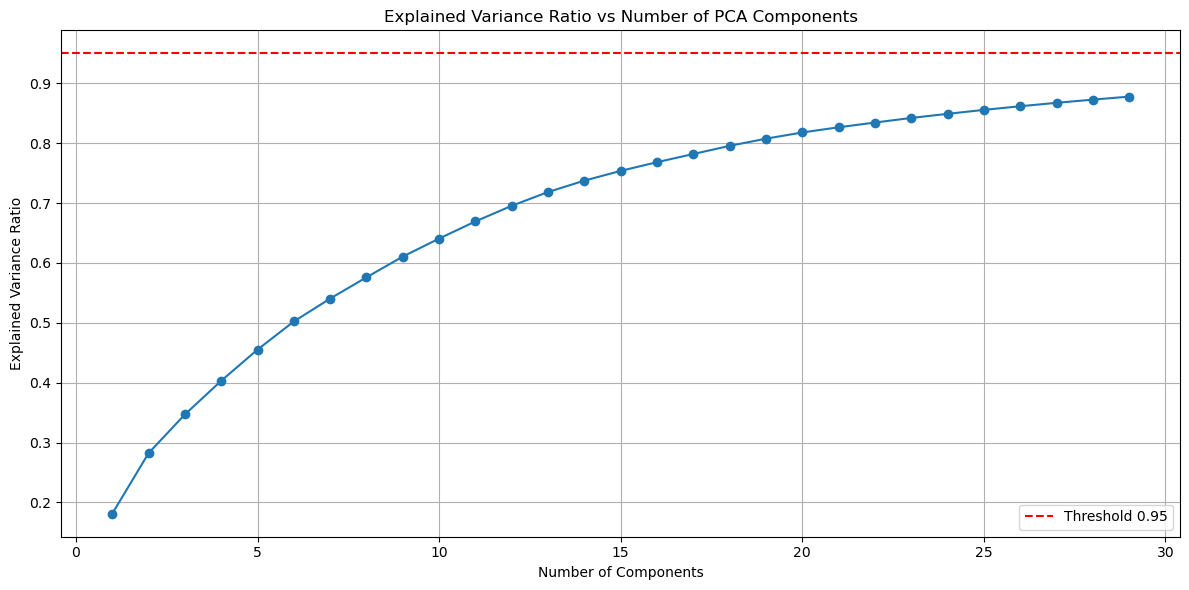

In [25]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define a range of n_components to explore
n_components_range = range(1, 30, 1)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
n_components = 10
bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 1, lag 0
X period: 1997-02-28 00:00:00 - 2015-11-30 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 1
X period: 1997-03-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 2
X period: 1997-04-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 3
X period: 1997-05-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 4
X period: 1997-06-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 5
X period: 1997-07-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 6
X period: 1997-08-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 7
X period: 1997-09-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 8
X period: 1997-

In [27]:
horizon = 2
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

n_components = 10
bic_values_h2 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h2.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h2)
lowest_bic = min(bic_values_h2)

print("BIC values for different lag lengths:", bic_values_h2)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Horizon 2, lag 0
X period: 1997-03-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 1
X period: 1997-04-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 2
X period: 1997-05-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 3
X period: 1997-06-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 4
X period: 1997-07-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 5
X period: 1997-08-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 6
X period: 1997-09-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00

In [28]:
horizon = 3
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)

n_components = 10
bic_values_h3 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=horizon)
    bic_values_h3.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h3)
lowest_bic = min(bic_values_h3)

print("BIC values for different lag lengths:", bic_values_h3)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Horizon 3, lag 0
X period: 1997-04-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 1
X period: 1997-05-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 2
X period: 1997-06-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 3
X period: 1997-07-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 4
X period: 1997-08-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 5
X period: 1997-09-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-12-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 6
X period: 1997-10-31 00:00:00 - 2015-09-30 00:00:00
y period: 1998-01-31 00:00:00 - 2015-12-31 00